In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import json
from numpy import array
from numpy import asarray
from numpy import zeros


# For evaluation and embedding process
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Import self defined functions for simple model design
import Functions.Modeling_functions as mf

In [2]:
review_A = []
for line in open('Toys_and_Games_5.json', 'r'):
    review_A.append(json.loads(line))

df = pd.DataFrame(review_A)

print(df.isnull().values.any())

df.shape

True


(167597, 9)

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VXOAVRGKGEAK,0439893577,Angie,"[0, 0]",I like the item pricing. My granddaughter want...,5.0,Magnetic board,1390953600,"01 29, 2014"
1,A8R62G708TSCM,0439893577,Candace,"[1, 1]",Love the magnet easel... great for moving to d...,4.0,it works pretty good for moving to different a...,1395964800,"03 28, 2014"
2,A21KH420DK0ICA,0439893577,capemaychristy,"[1, 1]",Both sides are magnetic. A real plus when you...,5.0,love this!,1359331200,"01 28, 2013"
3,AR29QK6HPFYZ4,0439893577,dcrm,"[0, 0]",Bought one a few years ago for my daughter and...,5.0,Daughters love it,1391817600,"02 8, 2014"
4,ACCH8EOML6FN5,0439893577,DoyZ,"[1, 1]",I have a stainless steel refrigerator therefor...,4.0,Great to have so he can play with his alphabet...,1399248000,"05 5, 2014"


<AxesSubplot:xlabel='overall', ylabel='count'>

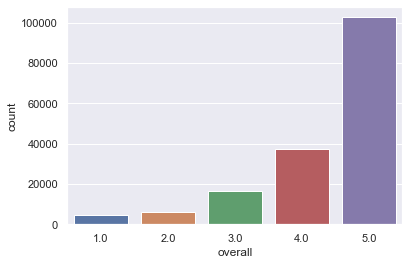

In [4]:
sns.countplot(x='overall', data=df)

In [6]:
X = []
sentences = list(df['reviewText'])
for sen in sentences:
    X.append(mf.pre_pro().preprocess_text(inputSentence=sen))

X[0]

'I like the item pricing My granddaughter wanted to mark on it but wanted it just for the letters '

In [7]:
y = df['overall']

y = np.array(list(map(lambda x: 1 if x>3 else 0, y)))
y

array([1, 1, 1, ..., 1, 1, 1])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
#using keras tokenizer
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
len(X_train), len(X_test)

(134077, 33520)

In [11]:
type(X_train), type(y_train)

(list, numpy.ndarray)

In [12]:
#We set the maximum size of each list to 100. You can try a different size. The lists with size greater than 100 will be truncated to 100. 
#For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size #Unique words

69469

In [13]:
embeddings_dictionary = dict()

#Download it from https://www.kaggle.com/datasets/danielwillgeorge/glove42B300dtxt
glove_file = open('glove.42B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [14]:
embedding_matrix = zeros((vocab_size, 300)) #This matrix will have 300 rows as the pretrained weight
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [15]:
embedding_matrix.shape
#Each word has a one row and find 100 dimension of related words

(69469, 300)

## Set up early stopping

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=4)

# Simple neural network
#### Initiate the model through simple disgns

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          20840700  
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 1)                 30001     
                                                                 
Total params: 20,870,701
Trainable params: 30,001
Non-trainable params: 20,840,700
_________________________________________________________________


2022-08-25 15:02:29.490466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None


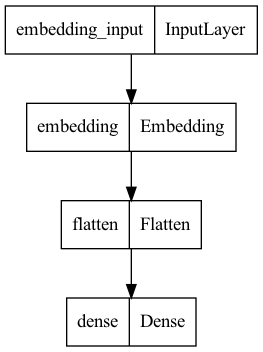

In [17]:
m1 = mf.self_model(vocab_size,embedding_matrix,d=300).simpleNN()
plot_model(m1)

#### Train the model

In [18]:
# The validation_split of 0.2 means that 20% of the training data is used to find the training accuracy of the algorithm.
history = m1.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2,callbacks=[es])
#If early stop is not needed, use the following code
#history = m1.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
838/838 [==============================] - 5s 6ms/step - loss: 0.3791 - acc: 0.8386 - val_loss: 0.3541 - val_acc: 0.8474
Epoch 2/20
838/838 [==============================] - 3s 4ms/step - loss: 0.3097 - acc: 0.8690 - val_loss: 0.3664 - val_acc: 0.8490
Epoch 3/20
838/838 [==============================] - 4s 4ms/step - loss: 0.2866 - acc: 0.8801 - val_loss: 0.3763 - val_acc: 0.8449
Epoch 4/20
838/838 [==============================] - 4s 4ms/step - loss: 0.2676 - acc: 0.8890 - val_loss: 0.3940 - val_acc: 0.8420
Epoch 5/20
838/838 [==============================] - 4s 4ms/step - loss: 0.2567 - acc: 0.8940 - val_loss: 0.3974 - val_acc: 0.8486
Epoch 5: early stopping


1048/1048 [==============================] - 1s 1ms/step - loss: 0.4091 - acc: 0.8419
Test Score: 0.4090718626976013
Test Accuracy: 0.8419152498245239


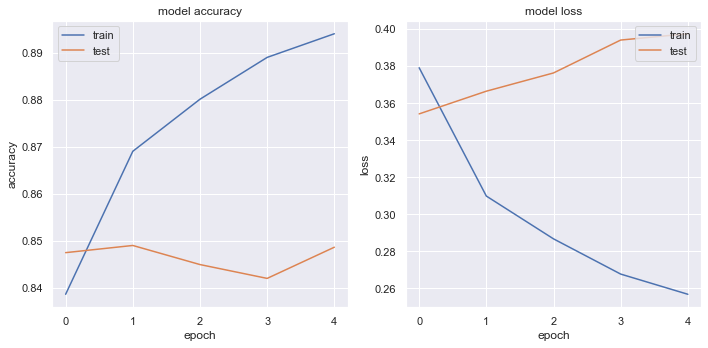

In [21]:
score = m1.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
mf.performance_evplot(history)

# LSTM Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          20840700  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,060,477
Trainable params: 219,777
Non-trainable params: 20,840,700
_________________________________________________________________
None


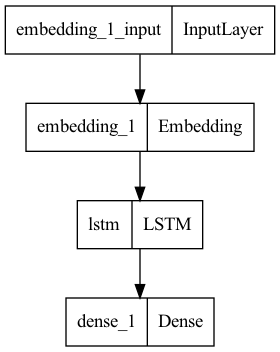

In [22]:
modelLSTM = mf.self_model(vocab_size,embedding_matrix,d=300).LSTM()
plot_model(modelLSTM)

In [23]:
history2 = modelLSTM.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2,callbacks=[es])

Epoch 1/15
838/838 [==============================] - 134s 158ms/step - loss: 0.4019 - acc: 0.8397 - val_loss: 0.3041 - val_acc: 0.8647
Epoch 2/15
838/838 [==============================] - 129s 154ms/step - loss: 0.2843 - acc: 0.8789 - val_loss: 0.2570 - val_acc: 0.8915
Epoch 3/15
838/838 [==============================] - 130s 155ms/step - loss: 0.2593 - acc: 0.8909 - val_loss: 0.2474 - val_acc: 0.8960
Epoch 4/15
838/838 [==============================] - 136s 162ms/step - loss: 0.2404 - acc: 0.9006 - val_loss: 0.2393 - val_acc: 0.9011
Epoch 5/15
838/838 [==============================] - 136s 163ms/step - loss: 0.2265 - acc: 0.9078 - val_loss: 0.2314 - val_acc: 0.9032
Epoch 6/15
838/838 [==============================] - 134s 160ms/step - loss: 0.2118 - acc: 0.9149 - val_loss: 0.2320 - val_acc: 0.9054
Epoch 7/15
838/838 [==============================] - 131s 157ms/step - loss: 0.1956 - acc: 0.9216 - val_loss: 0.2286 - val_acc: 0.9083
Epoch 8/15
838/838 [============================

1048/1048 [==============================] - 24s 23ms/step - loss: 0.2857 - acc: 0.8984
Test Score: 0.2857378423213959
Test Accuracy: 0.8983591794967651


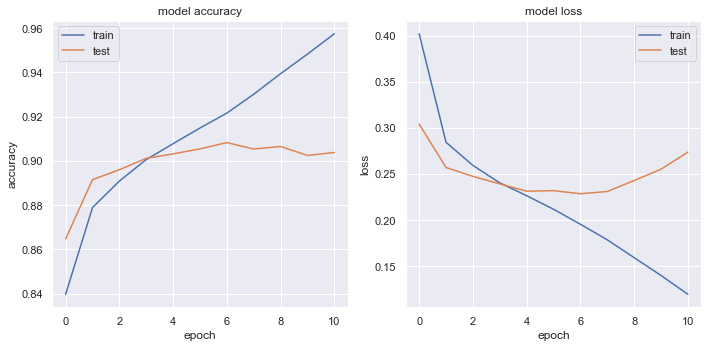

In [24]:
score2 = modelLSTM.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score2[0])
print("Test Accuracy:", score2[1])
mf.performance_evplot(history2)

In [25]:
 modelLSTM.save('LSTM.h5')

# Bi-LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          20840700  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,280,253
Trainable params: 439,553
Non-trainable params: 20,840,700
_________________________________________________________________
None


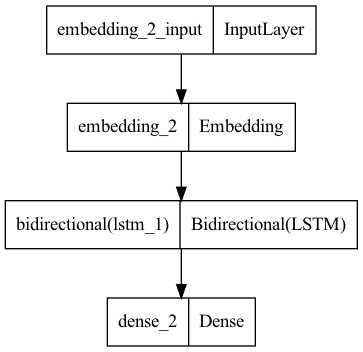

In [26]:
modelbiLSTM = mf.self_model(vocab_size,embedding_matrix,d=300).bi_LSTM()
plot_model(modelbiLSTM)

In [28]:
history3 = modelbiLSTM.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2,callbacks=[es])

Epoch 1/15
838/838 [==============================] - 237s 279ms/step - loss: 0.3111 - acc: 0.8672 - val_loss: 0.2546 - val_acc: 0.8930
Epoch 2/15
838/838 [==============================] - 235s 280ms/step - loss: 0.2451 - acc: 0.8982 - val_loss: 0.2341 - val_acc: 0.9040
Epoch 3/15
838/838 [==============================] - 236s 281ms/step - loss: 0.2192 - acc: 0.9110 - val_loss: 0.2218 - val_acc: 0.9082
Epoch 4/15
838/838 [==============================] - 239s 286ms/step - loss: 0.1994 - acc: 0.9191 - val_loss: 0.2274 - val_acc: 0.9077
Epoch 5/15
838/838 [==============================] - 239s 285ms/step - loss: 0.1772 - acc: 0.9289 - val_loss: 0.2257 - val_acc: 0.9082
Epoch 6/15
838/838 [==============================] - 239s 286ms/step - loss: 0.1516 - acc: 0.9409 - val_loss: 0.2393 - val_acc: 0.9068
Epoch 7/15
838/838 [==============================] - 237s 283ms/step - loss: 0.1205 - acc: 0.9546 - val_loss: 0.2676 - val_acc: 0.9063
Epoch 7: early stopping


1048/1048 [==============================] - 37s 35ms/step - loss: 0.2791 - acc: 0.9031
Test Score: 0.2790515720844269
Test Accuracy: 0.903132438659668


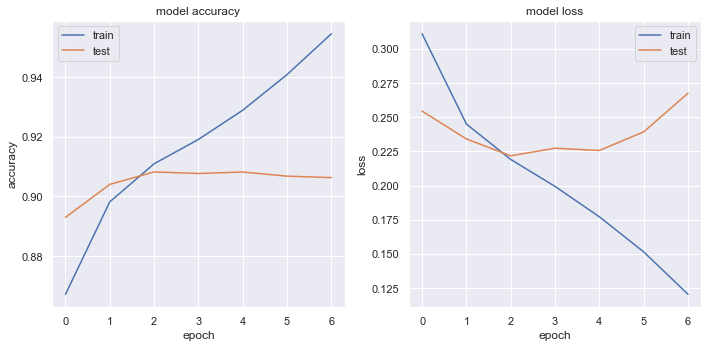

In [29]:
score3 = modelbiLSTM.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score3[0])
print("Test Accuracy:", score3[1])
mf.performance_evplot(history3)

In [31]:
modelbiLSTM.save('biLSTM.h5')

# Bi-LSTM with Attention Layer

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          20840700  
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 attention (Attention)       (None, 100, 256)          356       
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,477,601
Trainable params: 636,901
Non-trainable params: 20,840,700
____________________________________

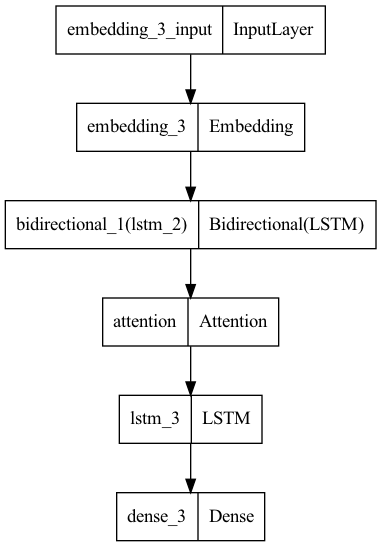

In [27]:
modelbiLSTM_A = mf.self_model(vocab_size,embedding_matrix,d=300).bi_LSTM(Att=True)
plot_model(modelbiLSTM_A)

In [32]:
history4 = modelbiLSTM_A.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2,callbacks=[es])

Epoch 1/15
838/838 [==============================] - 427s 506ms/step - loss: 0.4193 - acc: 0.8354 - val_loss: 0.3932 - val_acc: 0.8475
Epoch 2/15
838/838 [==============================] - 427s 510ms/step - loss: 0.4123 - acc: 0.8346 - val_loss: 0.3326 - val_acc: 0.8411
Epoch 3/15
838/838 [==============================] - 427s 509ms/step - loss: 0.2939 - acc: 0.8718 - val_loss: 0.2629 - val_acc: 0.8886
Epoch 4/15
838/838 [==============================] - 427s 509ms/step - loss: 0.2520 - acc: 0.8955 - val_loss: 0.2397 - val_acc: 0.9019
Epoch 5/15
838/838 [==============================] - 425s 507ms/step - loss: 0.2305 - acc: 0.9055 - val_loss: 0.2345 - val_acc: 0.9035
Epoch 6/15
838/838 [==============================] - 426s 509ms/step - loss: 0.2131 - acc: 0.9143 - val_loss: 0.2265 - val_acc: 0.9077
Epoch 7/15
838/838 [==============================] - 444s 529ms/step - loss: 0.1966 - acc: 0.9220 - val_loss: 0.2247 - val_acc: 0.9077
Epoch 8/15
838/838 [============================

1048/1048 [==============================] - 61s 58ms/step - loss: 0.2861 - acc: 0.8986
Test Score: 0.2861039936542511
Test Accuracy: 0.8985680341720581


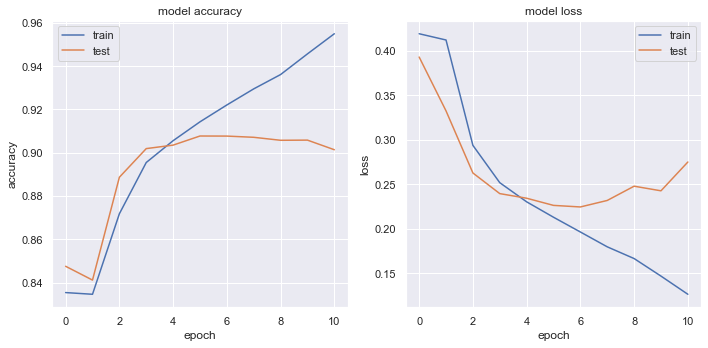

In [33]:
score4 = modelbiLSTM_A.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score4[0])
print("Test Accuracy:", score4[1])
mf.performance_evplot(history4)